<a href="https://colab.research.google.com/github/javanmesh/AI-Water-Monitoring/blob/main/ForestLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Satellite Change Detection - Sljeme Case Study**

In [15]:
!pip install -q geemap earthengine-api

In [21]:
import ee
import geemap
from IPython.display import display, HTML

project_id = 'bioguard-486011'

try:
    ee.Initialize(project=project_id)
    print(" Verification Success! BioGuard is active.")

    test_image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').first()
    print(" Data connection verified. Ready to analyze Sljeme!")
except Exception as e:
    print(f" Error: {e}")
    ee.Authenticate()
    ee.Initialize(project=project_id)

 Verification Success! BioGuard is active.
 Data connection verified. Ready to analyze Sljeme!


# Comparison of Sentinel-2 Multispectral Data (2020 vs 2025) to identify forest canopy loss on Mount Medvednica

In [25]:
import ee
import geemap

# 1. Initialize
project_id = 'bioguard-486011'
ee.Initialize(project=project_id)

# 2. Define Sljeme Area
roi = ee.Geometry.Point([15.962664085325798, 45.89687322821107]).buffer(7000) # 7km radius

# 3. Function to calculate NDVI
def get_ndvi(image):
    return image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# 4. Fetch 2020 (Baseline) vs 2024/25 (Current)
before = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(roi)
          .filterDate('2020-06-01', '2020-09-30')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .median())

after = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
         .filterBounds(roi)
         .filterDate('2024-06-01', '2025-09-30')
         .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
         .median())

# 5. Calculate NDVI
ndvi_before = get_ndvi(before).clip(roi)
ndvi_after = get_ndvi(after).clip(roi)

# 6. Calculate the CHANGE (Loss)
# Values below 0 show where vegetation decreased
change = ndvi_after.subtract(ndvi_before)

# 7. Visualize
Map = geemap.Map(center=[45.89687322821107, 15.962664085325798], zoom=12)

# --- NEW: Add Esri Satellite Basemap ---
Map.add_basemap('Esri.WorldImagery')

# Visualization: Red is loss, Green is gain, White is no change
change_params = {
    'min': -0.3,
    'max': 0.3,
    'palette': ['#e31a1c', '#ffffff', '#33a02c'] # Red to White to Green
}

Map.addLayer(ndvi_before, {'min': 0, 'max': 0.8, 'palette': ['white', 'green']}, 'Forest Health 2020')
Map.addLayer(change, change_params, 'Vegetation Change (RED = Tree Loss)')

Map.add_colorbar(change_params, label="Vegetation Health Change (Red = Loss)")

Map

Map(center=[45.89687322821107, 15.962664085325798], controls=(WidgetControl(options=['position', 'transparent_…

**We utilize the Normalized Difference Vegetation Index (NDVI) to detect changes in photosynthetic activity. Red areas indicate a significant drop in vegetation health, likely representing tree loss or storm damage.**

🌲 SLJEME FOREST HEALTH ANALYSIS (2020 → 2024)

📍 Study Area: 7km radius around Sljeme
   Total Area: 15393.79 hectares

🔴 Severe Loss (NDVI < -0.3):       45.12 ha
🟠 Moderate Loss (NDVI -0.2 to -0.3):    66.46 ha
🟡 Mild Loss (NDVI -0.1 to -0.2):   353.98 ha
────────────────────────────────────────
📊 TOTAL FOREST LOSS:              465.57 ha


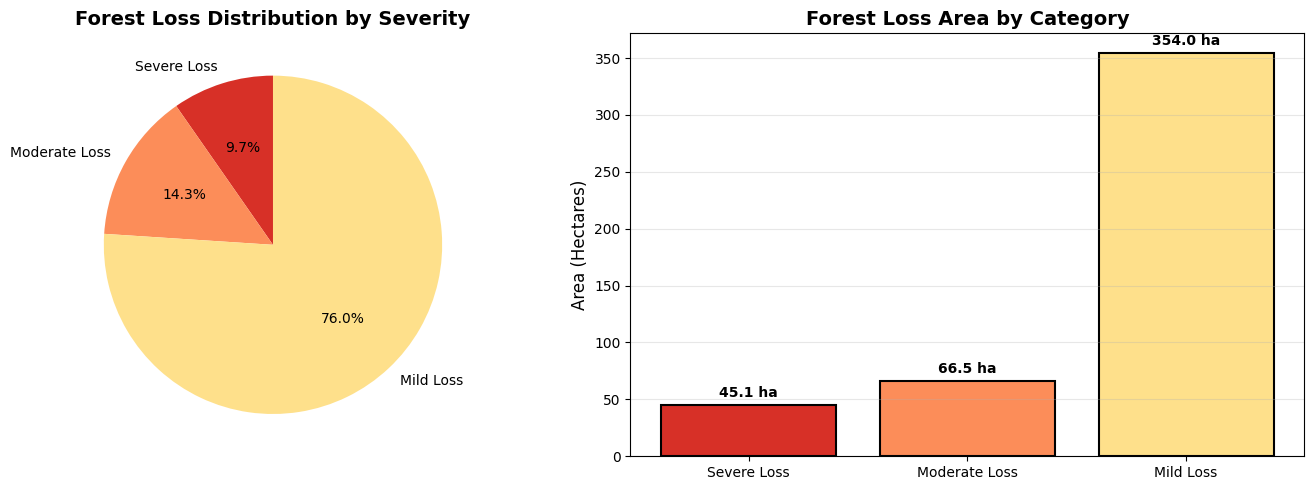

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate loss at different severity levels
loss_severe = change.lt(-0.3)  # Severe loss
loss_moderate = change.lt(-0.2).And(change.gte(-0.3))  # Moderate loss
loss_mild = change.lt(-0.1).And(change.gte(-0.2))  # Mild loss

# Calculate areas
def calculate_area(mask):
    stats = mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    return stats.get('NDVI').getInfo() / 10000  # Convert to hectares

area_severe = calculate_area(loss_severe)
area_moderate = calculate_area(loss_moderate)
area_mild = calculate_area(loss_mild)
total_loss = area_severe + area_moderate + area_mild

# Print results with formatting
print("=" * 60)
print("🌲 SLJEME FOREST HEALTH ANALYSIS (2020 → 2024)")
print("=" * 60)
print(f"\n📍 Study Area: 7km radius around Sljeme")
print(f"   Total Area: {(7000**2 * 3.14159) / 10000:.2f} hectares\n")
print(f"🔴 Severe Loss (NDVI < -0.3):    {area_severe:>8.2f} ha")
print(f"🟠 Moderate Loss (NDVI -0.2 to -0.3): {area_moderate:>8.2f} ha")
print(f"🟡 Mild Loss (NDVI -0.1 to -0.2): {area_mild:>8.2f} ha")
print(f"{'─' * 40}")
print(f"📊 TOTAL FOREST LOSS:            {total_loss:>8.2f} ha")
print("=" * 60)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
categories = ['Severe Loss', 'Moderate Loss', 'Mild Loss']
areas = [area_severe, area_moderate, area_mild]
colors = ['#d73027', '#fc8d59', '#fee08b']

ax1.pie(areas, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Forest Loss Distribution by Severity', fontsize=14, fontweight='bold')

# Bar chart
ax2.bar(categories, areas, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Area (Hectares)', fontsize=12)
ax2.set_title('Forest Loss Area by Category', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (cat, area) in enumerate(zip(categories, areas)):
    ax2.text(i, area + max(areas)*0.02, f'{area:.1f} ha',
             ha='center', fontweight='bold')

plt.tight_layout()
plt.show()